# FLAML demo

Autorzy: Sebastian David Botero Leonik, Bartosz Pokora, Franciszek Saliński

Agenda:
1. Czym jest FLAML?
2. Dane i baseline model
3. AutoML z FLAML
4. Porównanie wyników i wnioski

## Czym jest FLAML?

**FLAML** to open-source'owa biblioteka AutoML stworzona przez badaczy z Microsoft.

FLAML = *Fast and Lightweight AutoML Library* / *A Fast Library for Automated Machine Learning*

Źródła:
- [Dokumentacja FLAML](https://microsoft.github.io/FLAML/)
- [Repozytorium FLAML na GitHubie](https://github.com/microsoft/FLAML)
- [Publikacja FLAML](https://arxiv.org/pdf/1911.04706)

Główne cechy FLAML:
- Automatyzuje wybór modelu i optymalizację hiperparametrów
- Szybkość i lekkość, pozwala na ustalenie `time_budget`
- Używa API zgodnego z scikit-learn
- Obsługuje różne zadania ML: klasyfikacja, regresja, klasteryzacja, prognozowanie szeregów czasowych,...

In [1]:
# Instalacja FLAML
#!pip install flaml[automl]

In [2]:
# Importy
import warnings
warnings.filterwarnings("ignore")

import time

from flaml import AutoML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)

## Dane i baseline model

Wykorzystamy zbiór danych z **OpenML**: `bank-marketing`. Na początek zbudujemy prosty pipeline z modelem regresji logistycznej, ocenimy jego jakość i zmierzymy czas trenowania.

Dane: [bank-marketing dataset](https://www.openml.org/search?type=data&sort=runs&id=1461&status=active)

In [3]:
X, y = fetch_openml(data_id=1461, as_frame=True, return_X_y=True)

# Zamiana etykiet na 0/1
y = y.astype(str)
y = (y == "2").astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

X_train.shape, X_test.shape

((36168, 16), (9043, 16))

In [4]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16
15136,37,technician,married,secondary,no,101,no,no,cellular,17,jul,130,1,-1,0,unknown
35784,46,management,married,secondary,no,1098,no,no,cellular,8,may,99,3,343,3,other
36799,50,management,married,primary,no,15035,yes,no,cellular,12,may,158,1,-1,0,unknown
21070,46,blue-collar,married,primary,no,648,no,no,cellular,14,aug,59,4,-1,0,unknown
18565,49,services,married,secondary,no,4697,yes,no,cellular,31,jul,66,1,-1,0,unknown


In [5]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print(f"Liczba cech: {X_train.shape[1]}")
print(f"Zmienne numeryczne: {num_cols}")
print(f"Zmienne kategoryczne: {cat_cols}")

Liczba cech: 16
Zmienne numeryczne: ['V1', 'V6', 'V10', 'V12', 'V13', 'V14', 'V15']
Zmienne kategoryczne: ['V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9', 'V11', 'V16']


In [6]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()
X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names, index=X_train.index)
X_test_prep  = pd.DataFrame(X_test_prep,  columns=feature_names, index=X_test.index)

In [7]:
log_reg = LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_STATE)

param_grid = {
    "C": [0.1, 0.25, 0.5, 1, 2, 4, 10],
    "penalty": ["l1", "l2"],
}

grid_search = GridSearchCV(
    log_reg,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

start_time = time.time()
grid_search.fit(X_train_prep, y_train)
end_time = time.time()

train_time_baseline = end_time - start_time

best_model = grid_search.best_estimator_
test_proba = best_model.predict_proba(X_test_prep)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

accuracy_baseline = accuracy_score(y_test, test_pred)
roc_auc_baseline = roc_auc_score(y_test, test_proba)

print("Najlepsze parametry:", grid_search.best_params_)
print(f"Training time: {train_time_baseline:.4f} seconds")
print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"ROC AUC: {roc_auc_baseline:.4f}")

Najlepsze parametry: {'C': 0.1, 'penalty': 'l1'}
Training time: 42.7630 seconds
Accuracy: 0.9004
ROC AUC: 0.9003


## AutoML z FLAML

Użyjemy teraz FLAML do automatycznego znalezienia najlepszego modelu i jego hiperparametrów dla tego samego zadania klasyfikacji.

Do przetworzenia danych użyjemy tego samego pipeline'u co wcześniej.

In [8]:
automl = AutoML()

automl_settings = {
    "time_budget": 20,
    "metric": "roc_auc",
    "task": "classification",
    "seed": RANDOM_STATE,
    "estimator_list": ["rf", "extra_tree", "catboost", "lgbm"],
    "log_file_name": "flaml_automl.log",
}

start_time = time.time()
automl.fit(X_train=X_train_prep, y_train=y_train, **automl_settings)
end_time = time.time()

train_time_flaml = end_time - start_time

print("Najlepszy estymator:", automl.best_estimator)
print("Najlepsza konfiguracja (best_config):")
print(automl.best_config)

[flaml.automl.logger: 01-03 22:50:55] {1752} INFO - task = classification
[flaml.automl.logger: 01-03 22:50:55] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 01-03 22:50:55] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-03 22:50:55] {1979} INFO - List of ML learners in AutoML Run: ['rf', 'extra_tree', 'catboost', 'lgbm']
[flaml.automl.logger: 01-03 22:50:55] {2282} INFO - iteration 0, current learner rf
[flaml.automl.logger: 01-03 22:50:55] {2417} INFO - Estimated sufficient time budget=2617s. Estimated necessary time budget=3s.
[flaml.automl.logger: 01-03 22:50:55] {2466} INFO -  at 1.2s,	estimator rf's best error=0.2469,	best estimator rf's best error=0.2469
[flaml.automl.logger: 01-03 22:50:55] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 01-03 22:50:56] {2466} INFO -  at 1.5s,	estimator lgbm's best error=0.1426,	best estimator lgbm's best error=0.1426
[flaml.automl.logger: 01-03 22:50:56] {2282} INFO - iteration 

In [9]:
test_proba = automl.predict_proba(X_test_prep)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

accuracy_flaml = accuracy_score(y_test, test_pred)
roc_auc_flaml = roc_auc_score(y_test, test_proba)

print(f"Training time (FLAML): {train_time_flaml:.4f} seconds")
print(f"Accuracy (FLAML): {accuracy_flaml:.4f}")
print(f"ROC AUC (FLAML): {roc_auc_flaml:.4f}")

Training time (FLAML): 27.5077 seconds
Accuracy (FLAML): 0.9110
ROC AUC (FLAML): 0.9348


## Porównanie wyników i wnioski

Porównajmy najlepsze hiperparametry oraz wyniki baseline'u i modelu znalezionego przez FLAML pod względem ROC AUC oraz czasu treningu.

In [10]:
print("=== Baseline ===")
print("Najlepszy estymator:", best_model)
print("Najlepsze parametry:", grid_search.best_params_)

print("\n=== FLAML ===")
print("Najlepszy estymator:", automl.best_estimator)
print("Najlepsze parametry:")
print(automl.best_config)

=== Baseline ===
Najlepszy estymator: LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=123,
                   solver='liblinear')
Najlepsze parametry: {'C': 0.1, 'penalty': 'l1'}

=== FLAML ===
Najlepszy estymator: catboost
Najlepsze parametry:
{'early_stopping_rounds': 10, 'learning_rate': 0.09999999999999996, 'n_estimators': 8192}


In [11]:
results = pd.DataFrame({
    "Model": ["LogReg + GSCV", "FLAML AutoML"],
    "ROC AUC (test)": [roc_auc_baseline, roc_auc_flaml],
    "Accuracy (test)": [accuracy_baseline, accuracy_flaml],
    "Czas treningu [s]": [train_time_baseline, train_time_flaml],
})

results["ROC AUC (test)"] = results["ROC AUC (test)"].round(4)
results["Accuracy (test)"] = results["Accuracy (test)"].round(4)
results["Czas treningu [s]"] = results["Czas treningu [s]"].round(3)

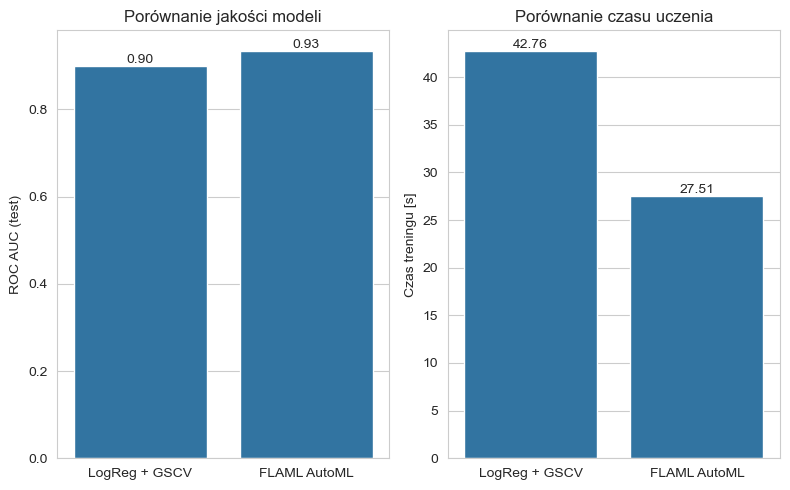

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

sns.barplot(
    data=results,
    x="Model",
    y="ROC AUC (test)",
    ax=ax[0]
)
ax[0].set_title("Porównanie jakości modeli")
ax[0].set_xlabel("")
ax[0].set_ylabel("ROC AUC (test)")
ax[0].bar_label(ax[0].containers[0], fmt="%.2f")

sns.barplot(
    data=results,
    x="Model",
    y="Czas treningu [s]",
    ax=ax[1]
)
ax[1].set_title("Porównanie czasu uczenia")
ax[1].set_xlabel("")
ax[1].set_ylabel("Czas treningu [s]")
ax[1].bar_label(ax[1].containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()

### Podsumowanie
- FLAML pozwala na automatyzację wyboru modelu i optymalizacji hiperparametrów w szybki i efektywny sposób
- Możemy łatwo zaoszczędzić czas, ilość kodu i zasoby obliczeniowe
- Na naszym przykładzie FLAML w krótszym czasie znalazł odrobinę lepszy model niż ręcznie stworzony pipeline z regresją logistyczną i GridSearchCV


### Dziękujemy za uwagę :)